In [7]:
%help

The following SysML v2 magic commands are available.
For help on a specific command, use "%help <COMMAND>" or "%<cmd> -h".

%eval		Evaluate a given expression.
%export		Save a file of the JSON representation of the abstract syntax tree rooted in the named element.
%help		Get a list of available commands or help on a specific command
%list		List loaded library packages or the results of a given query
%show		Print the abstract syntax tree rooted in a named element
%publish	Publish to the repository the modele elements rooted in a named element
%view		Render the view specified by the named view usage
%viz		Visualize the name model elements


In [5]:
%help %viz

Usage: %viz [--view=<VIEW>] [--style=<STYLE>...] <NAME> [<NAME>...]

Visualize model elements of <NAME>(s). <NAME>s must be fully qualified.

<VIEW> is case insensitive and possible candidates are:
   DEFAULT		Automatically choose an appropriate view from the given model element names
   TREE			Show a tree-structural view, like a Block Definition Diagram (BDD)
   INTERCONNECTION	Show an interconnection view, like an Internal Block Diagram (IBD)
   STATE		Show state machines
   ACTION		Show actions like an activity diagram
   SEQUENCE		Show events and messages in a sequence diagram
   MIXED		Show multiple views

<STYLE> is also case insensitive. Multiple --style options are allowed.  The possible style names are:
  DEFAULT		Standard B&&W
  STDCOLOR		Standard style with colors
  PLANTUML		PlantUML Style
  TB			Top-to-Bottom orientation
  LR			Left-to-Right orientation
  POLYLINE		Polyline style
  ORTHOLINE		Orthogonal line style
  SHOWLIB		Show elements of the standard libraries
  SHOWIN

In [910]:
package Metamodel {
    private import Definitions::*;
    part def System {
        doc /* Represents an engineered system ... */
        attribute problemStatement : ScalarValues::String {
            doc /* The problem is solved by the system. */
        }
        attribute systemIdea : ScalarValues::String {
            doc /* The elevator pitch of how the system solves the problem. */
        }
    }
    part systems[*] : System; // represents the set of all usages of the concept
    metadata def <system> SystemDSM specializes Metaobjects::SemanticMetadata {
        redefines baseType = systems meta SysML::Usage;
    }
    # system def Batmobile specializes Vehicle {
        redefines problemStatement := "As a Hero, Batman needs a cool vehicle.";
        redefines systemIdea := "The Batmobile is a black vehicle ...";
    }
}

Package Metamodel (ef60ddf2-a60e-440e-a116-4260125ee82e)


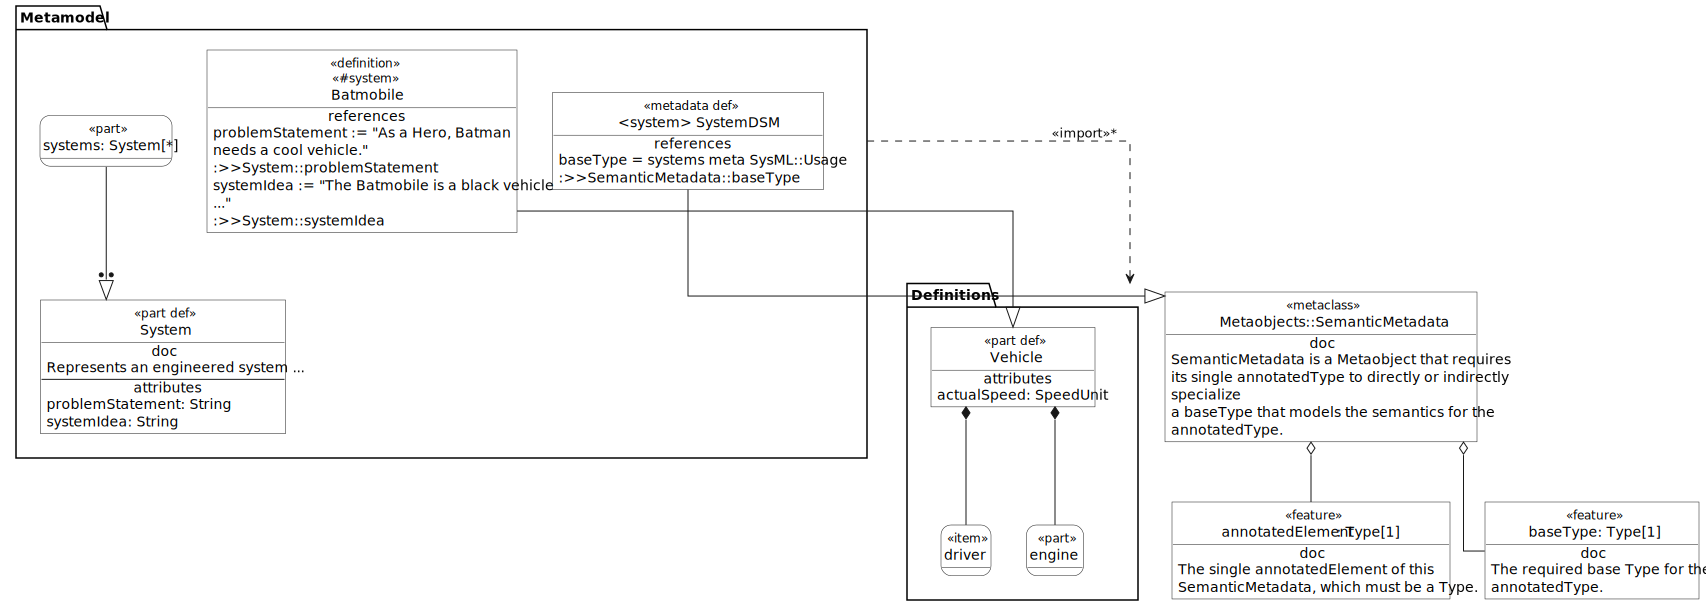

In [912]:
%viz --view=TREE --style=SHOWMETACLASS --style=SHOWIMPORTED --style=ORTHOLINE Metamodel

In [1048]:
package Viewpoints {
    part def HeroAssociation;
    concern 'Reduce the number of special parts' {
        doc /* Reduce the number of special parts ... */
        // stakeholder heroAss:: HeroAssociation; // not working
    }
    viewpoint 'system components' {
        frame 'Reduce the number of special parts';
        require constraint {
            doc /* Show the hierarchical part decomposition of a system. */
        }
    }
    view def 'Part list' {
        // satisfy 'system components'; // not working
        filter @SysML::PartUsage;
    }
    view batmobileParts : 'Part list' {
        expose Stage_4_Physical::batmobileDesignV23::*;
        render Views::asElementTable;
    }
}

Package Viewpoints (377bfd83-4393-40e8-99c4-8e4db2cf7000)


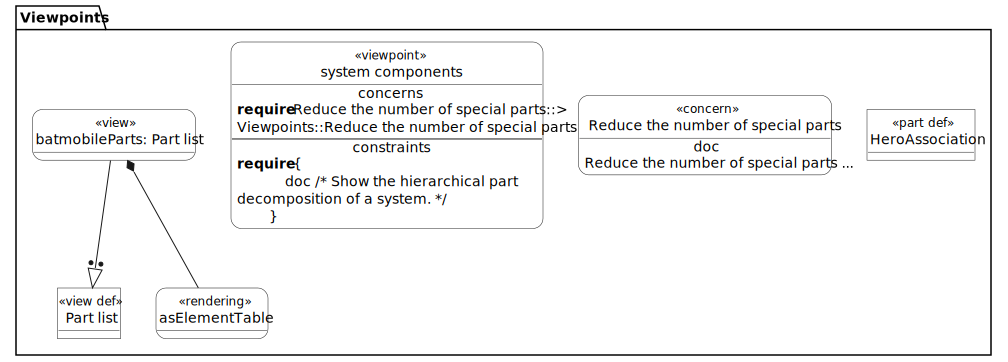

In [1050]:
%viz Viewpoints

In [986]:
package Requirements {
    private import Definitions::*;
    requirement def VehicleMaxSpeed {
        doc /* The actual speed of the vehicle shall be less than the maximun speed. */
        // stakeholder pm : ProductManagement; // not working
        subject vehicle : Vehicle;
        attribute maxSpeed : SI::SpeedUnit;
    }
    requirement batmobileSpecification {
        requirement <'REQ42'>
            batmobileMaxSpeed : VehicleMaxSpeed {
                redefines maxSpeed = 230 [SI::'km/h'];
            }
        requirement <'REQ43'>
            batmobileAcceleration;
    }
}

Package Requirements (486364eb-de27-404d-9636-ba9354e5c13e)


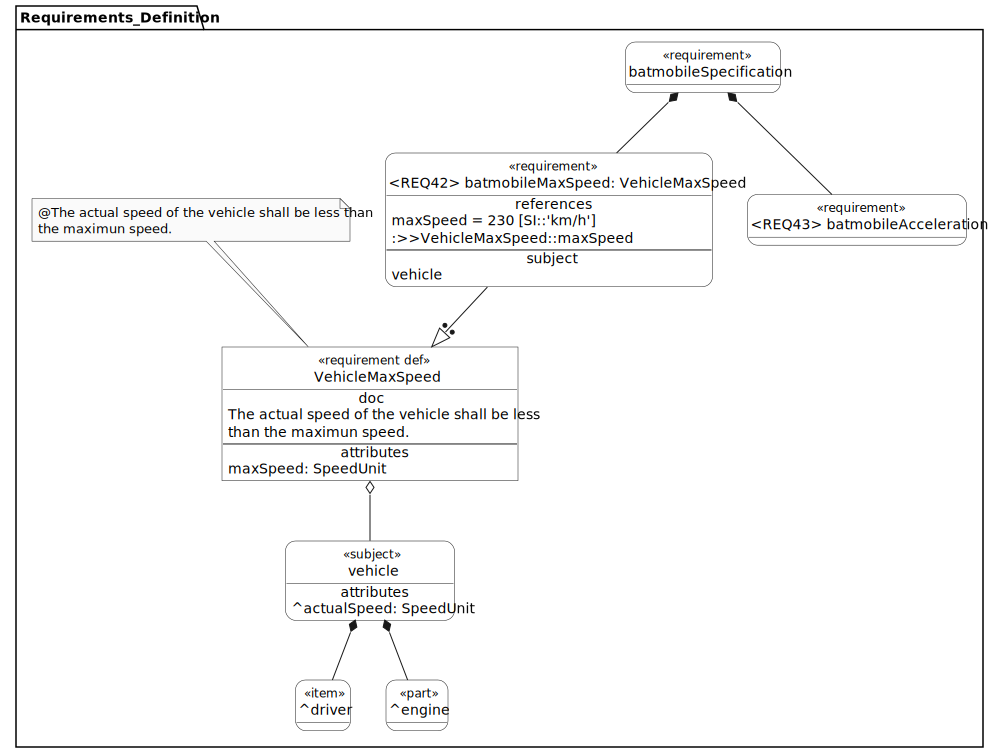

In [852]:
%viz --style=SHOWINHERITED Requirements_Definition

In [1080]:
package Definitions {
    private import Metamodel::*;
    item def Hero;
    part def Vehicle {
        item driver;
        part engine;
        attribute actualSpeed : SI::SpeedUnit;
    }
    part def Batmobile specializes Vehicle {
        part batmobileEngine : BatmobileEngine redefines engine {
            port enginePort : ~PowerIP;
        } 
        part seat[2];
        part body;
        part wheels[4] : Wheel;
        part frontLeftWheel subsets wheels;
        part frontRightWheel subsets wheels;
        part battery {
            port powerPort : PowerIP;
            attribute capacity;
        }
        interface battery2engine : PowerInterface connect 
            battery.powerPort to batmobileEngine.enginePort;
    }
    part def BatmobileNG specializes Batmobile {
        part bulletProofWheels[4] redefines wheels;
    }
    part def Wheel {
        attribute pressure;
        item boundingBox : ShapeItems::Box[1] subsets boundingShapes {
            redefines length : ISQ::LengthUnit = 80 [SI::cm];
            redefines width : ISQ::LengthUnit = 26 [SI::cm];
            redefines height : ISQ::LengthUnit = 80 [SI::cm];
        }
    }
    part def Engine {
        perform action rocketBoost {
            in cmd : EngineCommand = engineControl.cmd;
        }
        port engineControl {
            in item cmd : EngineCommand;
        }
    }
    part def BatmobileEngine;
    item def EngineCommand;
    port def PowerIP {
        out item power : Power;
    }
    item def Power {
        attribute value;
    }
    interface def PowerInterface {
        end supplierPort : PowerIP;
        end consumerPort : ~PowerIP;
        flow of Power from supplierPort.power to consumerPort.power;
    }
    enum def StatusKind {
        enum safe;
        enum alert;
    }
}

Package Definitions (33b5fb58-c4a9-4110-bc89-668067509c8f)


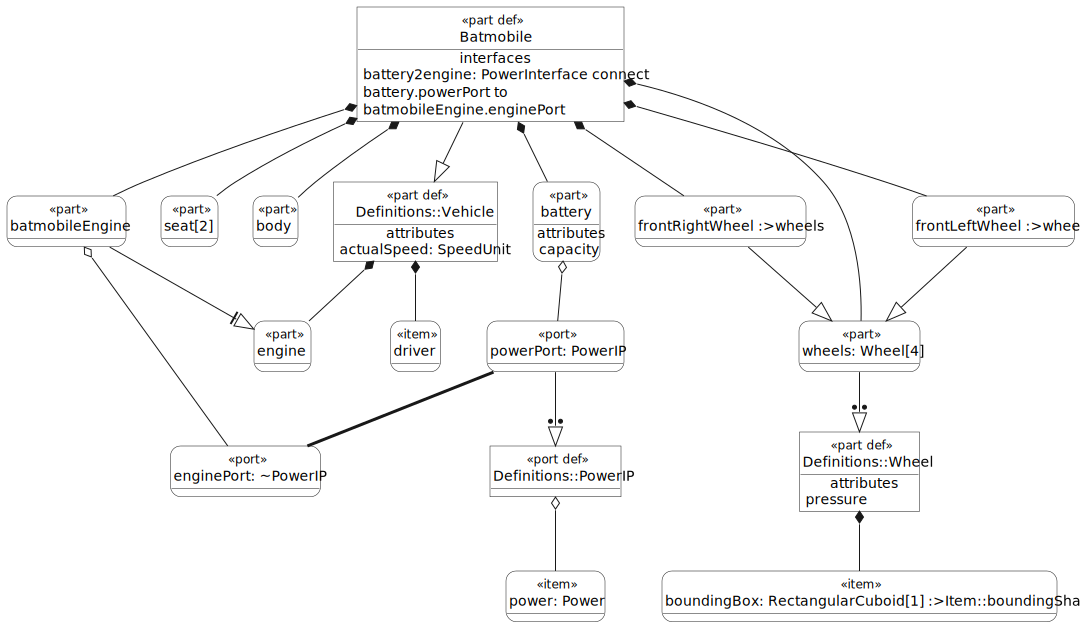

In [974]:
%viz --view=TREE --style=TB --style=SHOWIMPORTED Definitions::Batmobile

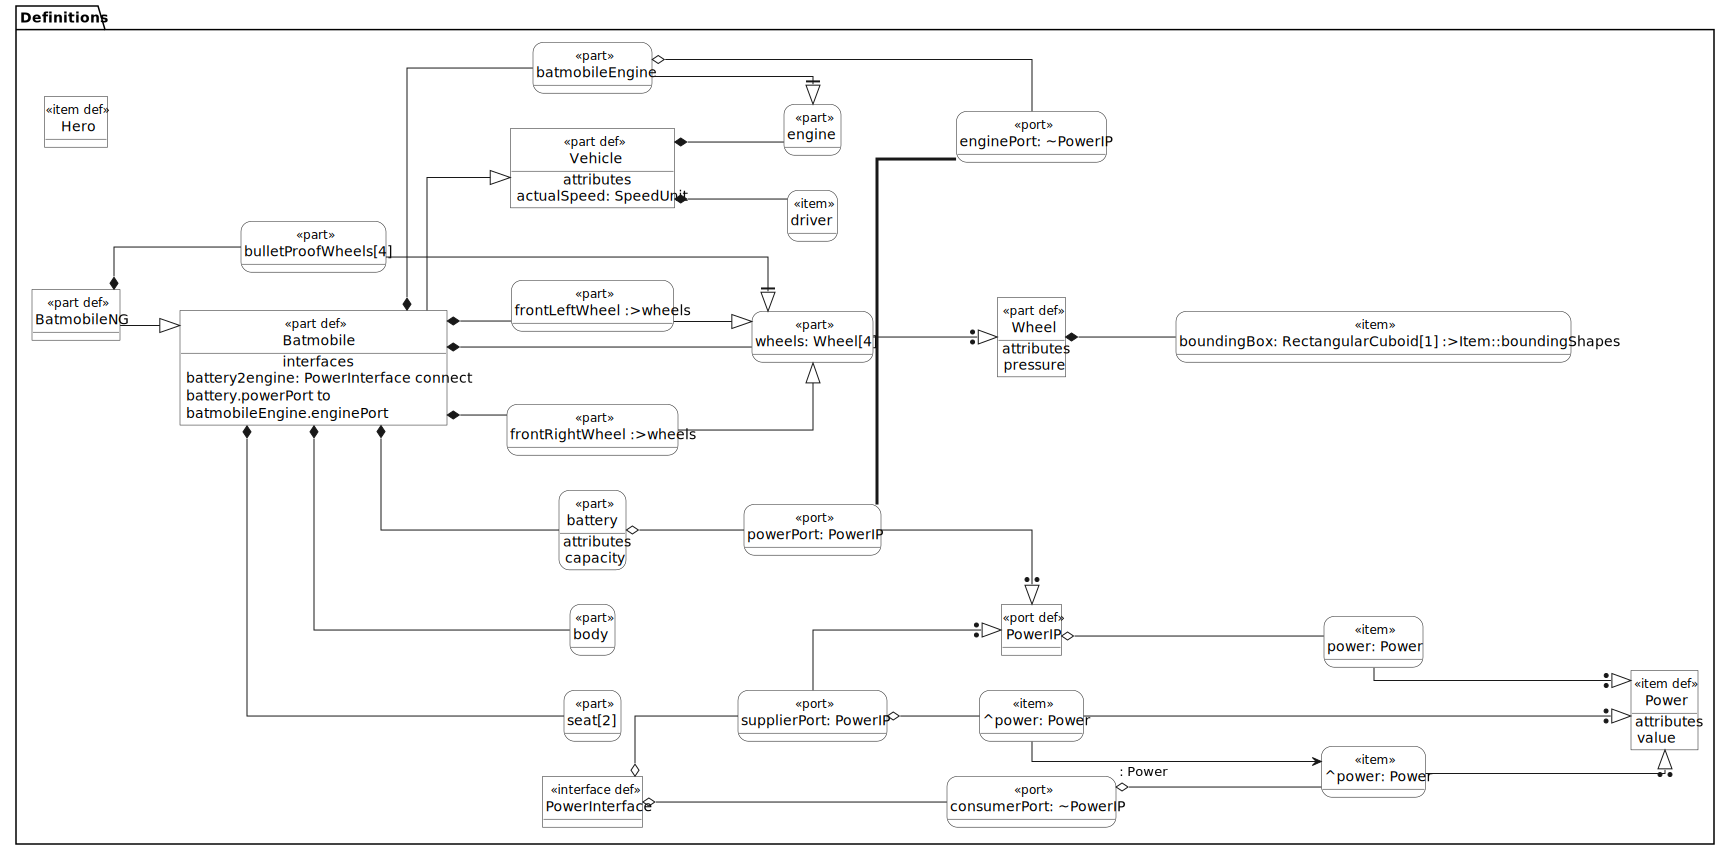

In [551]:
%viz --view=TREE --style=LR --style=ORTHOLINE Definitions

In [1136]:
package Variability {
    private import Definitions::*;
    
    part def StandardEngine specializes BatmobileEngine;
    part def XtremeEngine specializes BatmobileEngine;
    part def StandardWheel specializes Wheel;
    part def XtremeWheel specializes Wheel;
    
    variation part def EngineChoices specializes BatmobileEngine {
        variant part sEngine : StandardEngine;
        variant part xEngine : XtremeEngine;
    }
    
    variation part def WheelChoices specializes Wheel {
        variant part sWheel : StandardWheel;
        variant part xWheel : XtremeWheel;
    }
    
    part def BatmobileConfigurations :> Batmobile {
        part :>> batmobileEngine : EngineChoices;
        part :>> wheels[4] : WheelChoices;
        assert constraint {
            (batmobileEngine == batmobileEngine::xEngine and wheels == wheels.xWheel)
        }
    }
}

Package Variability (35887f08-1026-4158-9de8-34844f58320a)


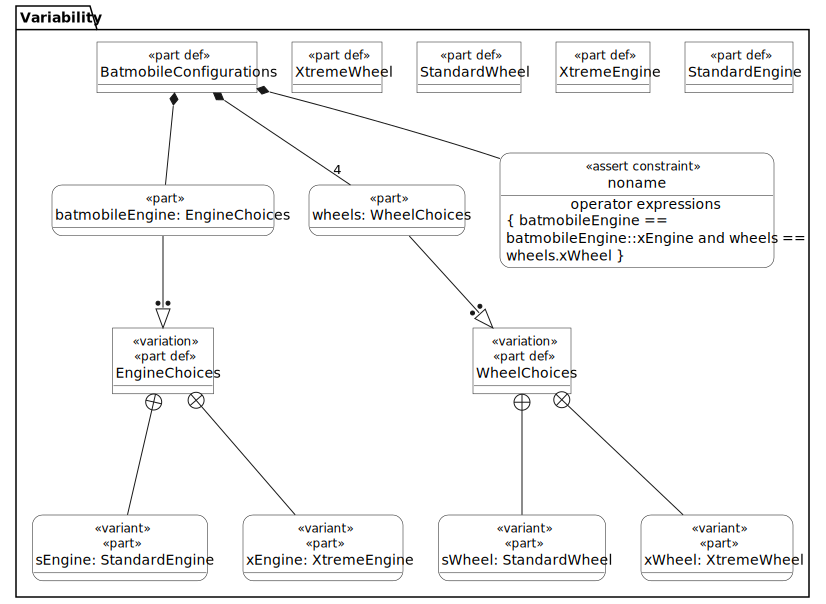

In [1142]:
%viz --view=MIXED Variability

In [594]:
package Batmobile_Architecture {
    // Inculed all stages
}

Package Batmobile_Architecture (51014a36-12cd-441a-83d9-345cc3bcd030)


In [606]:
package Stage_1_Capability {
    /* comment
    What the system does in the context?

    Scope:
    capability concept definition */
}
comment comment_1 about Stage_1_Capability /* not in scope */ 

Package Stage_1_Capability (c793af8f-023c-403e-91a7-dcda0fde2c69)
Comment comment_1 (0b054746-8ff6-43dd-b32a-500781e9ab7d)


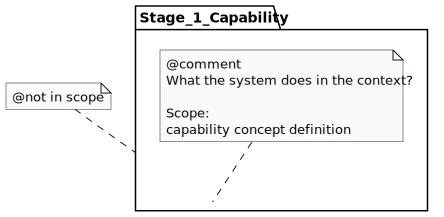

In [608]:
%viz Stage_1_Capability comment_1

In [752]:
package Stage_2_Operational {
    /* comment
    How the system is going to be used?
    
    Scope:
    operational use cases
    operational scenarios
    operational mission */

    private import Definitions::*;
    item batman : Hero {
        attribute realName = "Bruce Wayne";
    }
    item def ProductManagement;
    use case def 'Activate rocket booster' {
        subject bm : Batmobile;
        actor driver subsets batman;
        objective {
            doc /* The driver wants to activate the rocket booster to increase the speed extremely. */
        }
    }
    action def ActivateRocketBooster specializes 'Activate rocket booster' {
        first start;
        then action prepareBoost;
        then action activateBoost;
        then done;
    }
    part bm1 : Batmobile {
        timeslice batmanDriving {
            redefines driver = batman;
            snapshot redefines start {
                redefines battery.capacity = 40000 [SI::'watt hour'];
            }
            snapshot redefines done {
                redefines battery.capacity = 42 [SI::'watt hour'];
            }
        }
        then timeslice charging {
            redefines driver = null;
        }
    }
    action def Drive_Batmobile {
        first start;
        then action startBatmobile;
        then action scanEnvironment {
            out status : StatusKind;
        }
        then decide;
            if scanEnvironment.status == StatusKind::safe then Switch_to_standard_mode;
            if scanEnvironment.status == StatusKind::alert then Switch_to_alert_mode;
        action Switch_to_standard_mode;
        then endOfStatusCheck;
        action Switch_to_alert_mode;
        then endOfStatusCheck;
        merge endOfStatusCheck;
        then done;
    }
}

Package Stage_2_Operational (9cd9b166-d2b5-4865-ba13-4562fcf89824)


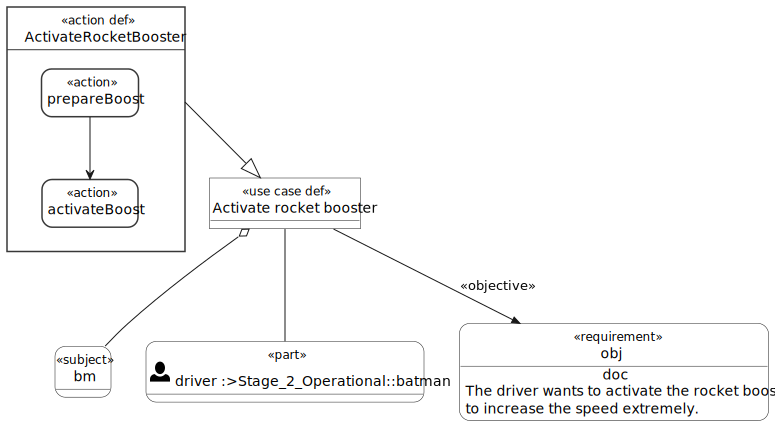

In [730]:
%viz --view=MIXED Stage_2_Operational::"Activate rocket booster" Stage_2_Operational::ActivateRocketBooster

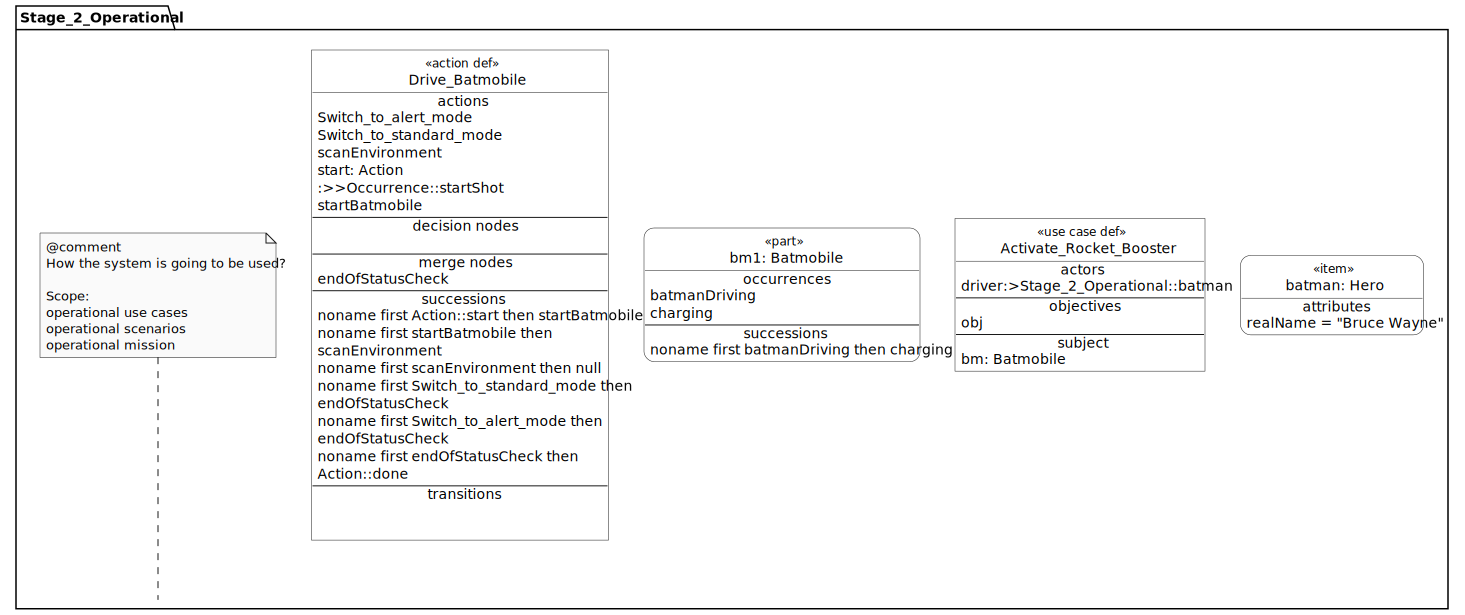

In [704]:
%viz --view=TREE --style=COMPMOST Stage_2_Operational

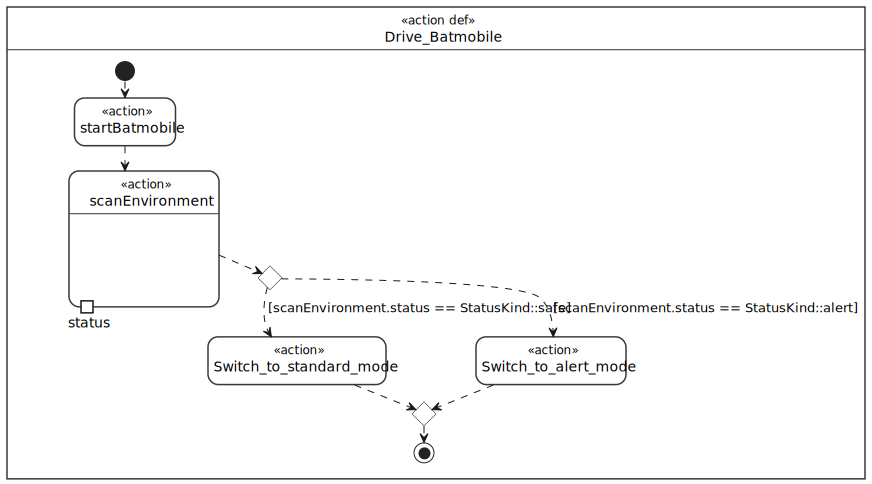

In [686]:
%viz --view=ACTION --style=TB --style=COMPMOST Stage_2_Operational::Drive_Batmobile

In [588]:
package Stage_3_Logical {
    /* comment
    What the system does?

    Scope:
    functional decomposition
    functional interfaces
    functional flows (energy, heat, matter, etc.)
    behaviours */
}

Package Stage_3_Logical (87faba37-e280-4094-98c8-cc6689303f8f)


In [838]:
package Stage_4_Physical {
    /*  comment
    How the system does it?
        
    Scope:
    physical breakdown
    physical interfaces (connectors)
    physical flows
    physical constrains
    mapping to logical stage */

    private import Requirements::*;
    private import Definitions::*;
    part batmobileDesignV23 : Batmobile;
    satisfy batmobileSpecification by batmobileDesignV23;
}

Package Stage_4_Physical (1c640ca6-227a-4ef9-a676-ef15132ac1e1)


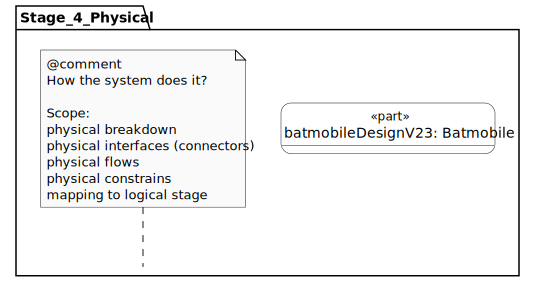

In [842]:
%viz --view=MIXED Stage_4_Physical